# Capstone: West Nile Virus Challenge
 
West Nile virus is most commonly spread to humans through infected mosquitos. Around 20% of people who become infected with the virus develop symptoms ranging from a persistent fever, to serious neurological illnesses that can result in death.

In 2002, the first human cases of West Nile virus were reported in Chicago. By 2004 the City of Chicago and the Chicago Department of Public Health (CDPH) had established a comprehensive surveillance and control program that is still in effect today.

Every week from late spring through the fall, mosquitos in traps across the city are tested for the virus. The results of these tests influence when and where the city will spray airborne pesticides to control adult mosquito populations.

Given weather, location, testing, and spraying data, we are asked to predict when and where different species of mosquitos will test positive for West Nile virus. A more accurate method of predicting outbreaks of West Nile virus in mosquitos will help the City of Chicago and CPHD more efficiently and effectively allocate resources towards preventing transmission of this potentially deadly virus.

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

pd.set_option('display.max_columns',1000)

from sklearn.linear_model import LogisticRegression, LinearRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, PowerTransformer
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve, average_precision_score, make_scorer, accuracy_score, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier, IsolationForest
from sklearn import naive_bayes
from sklearn.svm import SVC
from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE, SMOTENC, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from imblearn.pipeline import Pipeline, make_pipeline
from sklearn.decomposition import PCA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from datetime import datetime
from datetime import date

import tensorflow as tf

from six import StringIO
from sklearn.tree import export_graphviz
import pydotplus
from IPython.display import display
from IPython.display import Image

import pickle
from tkinter import Tk
from tkinter.filedialog import askopenfilename

import pylab as plt

## Data Loading and Cleaning

### Training and Test data:
The training set consists of data from 2007, 2009, 2011, and 2013, while in the test set we are requested 
to predict the test results for 2008, 2010, 2012, and 2014.

In [2]:
train = pd.read_csv('./datasets/train.csv')

# Make Date into datetime object, and index:
train['Date'] = pd.to_datetime(train.Date, format='%Y-%m-%d')
train.set_index('Date', inplace=True, drop=True)
train.head(1)

,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
Date,,,,,,,,,,,
2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,1,0


Calculating the baseline, we see a class imbalance: 5% of the training data tested positive for the virus.

In [3]:
print('Baseline = {}'.format(train.WnvPresent.value_counts(normalize=True).max()))
train.WnvPresent.value_counts()

Baseline = 0.9475537787930707


0    9955
1     551
Name: WnvPresent, dtype: int64

In [4]:
test = pd.read_csv('./datasets/test.csv')
# Make Date into datetime object, and index
test['Date'] = pd.to_datetime(test.Date, format='%Y-%m-%d')
test.set_index('Date', inplace=True, drop=True)
test.head(1)

,Id,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy
Date,,,,,,,,,,
2008-06-11,1,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9


### Weather Data:
It is believed that hot and dry conditions are more favorable for West Nile virus than cold and wet. 
We are provided with the dataset from NOAA of the weather conditions of 2007 to 2014, during the months of
the tests. 
    Station 1: CHICAGO O'HARE INTERNATIONAL AIRPORT Lat: 41.995 Lon: -87.933 Elev: 662 ft. above sea level
    Station 2: CHICAGO MIDWAY INTL ARPT Lat: 41.786 Lon: -87.752 Elev: 612 ft. above sea level

In [5]:
weather = pd.read_csv('./datasets/weather.csv')

# Make Date into datetime object, and index
weather['Date'] = pd.to_datetime(weather.Date, format='%Y-%m-%d')
weather.set_index('Date', inplace=True, drop=True)

# Data Cleaning:
weather['Tavg'] = pd.to_numeric(weather.apply(lambda x: (x['Tmin']+x['Tmax'])/2, axis=1))
weather['PrecipTotal'] = pd.to_numeric(weather.apply(lambda x: 0 if x['PrecipTotal']=='  T' or x['PrecipTotal']=='M' else x['PrecipTotal'], axis=1))


# Add Long / Lat:
weather.insert(1,'Latitude', weather.apply(lambda x: 41.995 if x['Station']==1 else 41.786, axis=1))
weather.insert(2,'Longitude', weather.apply(lambda x: -87.933 if x['Station']==1 else -87.752, axis=1))

weather.head(1)

,Station,Latitude,Longitude,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
Date,,,,,,,,,,,,,,,,,,,,,,,
2007-05-01,1,41.995,-87.933,83,50,66.5,14,51,56,0,2,0448,1849,,0,M,0.0,0.0,29.10,29.82,1.7,27,9.2


In [6]:
# Reformatting weather data into flattened version for merging with train data:
weather_station_1 = weather[weather['Station']==1]
weather_station_2 = weather[weather['Station']==2]

weather_df = weather_station_1.merge(weather_station_2,
                                     how='inner',
                                     on='Date',
                                     suffixes=('_station_1','_station_2'))

weather_df.head(1)

,Station_station_1,Latitude_station_1,Longitude_station_1,Tmax_station_1,Tmin_station_1,Tavg_station_1,Depart_station_1,DewPoint_station_1,WetBulb_station_1,Heat_station_1,Cool_station_1,Sunrise_station_1,Sunset_station_1,CodeSum_station_1,Depth_station_1,Water1_station_1,SnowFall_station_1,PrecipTotal_station_1,StnPressure_station_1,SeaLevel_station_1,ResultSpeed_station_1,ResultDir_station_1,AvgSpeed_station_1,Station_station_2,Latitude_station_2,Longitude_station_2,Tmax_station_2,Tmin_station_2,Tavg_station_2,Depart_station_2,DewPoint_station_2,WetBulb_station_2,Heat_station_2,Cool_station_2,Sunrise_station_2,Sunset_station_2,CodeSum_station_2,Depth_station_2,Water1_station_2,SnowFall_station_2,PrecipTotal_station_2,StnPressure_station_2,SeaLevel_station_2,ResultSpeed_station_2,ResultDir_station_2,AvgSpeed_station_2
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2007-05-01,1,41.995,-87.933,83,50,66.5,14,51,56,0,2,0448,1849,,0,M,0.0,0.0,29.10,29.82,1.7,27,9.2,2,41.786,-87.752,84,52,68.0,M,51,57,0,3,-,-,,M,M,M,0.0,29.18,29.82,2.7,25,9.6


#### PCA
Many weather features to comprehend, some of which are highly correlated as evidenced by the heatmap.
We will use the cumulated explained_variance_ratio to test this

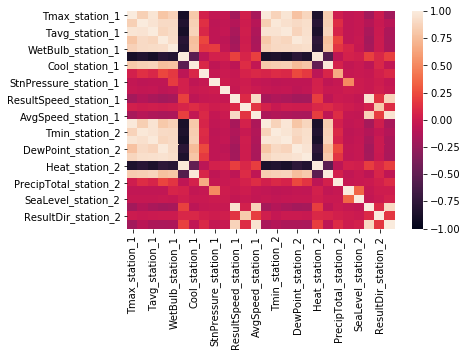

In [7]:
# Prepare a weather_pca dataframe with string dtypes converted to numeric, and standardise:
weather_pca = weather_df.drop(columns=['Station_station_1','Station_station_2',
                                       'Latitude_station_1','Longitude_station_1',
                                       'Latitude_station_2','Longitude_station_2',
                                       'Depth_station_1','Water1_station_1',
                                       'Depth_station_2','Water1_station_2',
                                       'Sunrise_station_1','Sunset_station_1',
                                       'Sunrise_station_2','Sunset_station_2',
                                       'Depart_station_1','Depart_station_2',
                                       'SnowFall_station_1','SnowFall_station_2',
                                       'CodeSum_station_1','CodeSum_station_2']).replace({'M':0,'  T':0, '-':0}).apply(pd.to_numeric)
scaler = StandardScaler()
weather_pca = pd.DataFrame(scaler.fit_transform(weather_pca), columns=weather_pca.columns)

# Check heatmap for any correlations that would be helped with PCA:
sns.heatmap(weather_pca.corr(), vmin=-1, vmax=1);

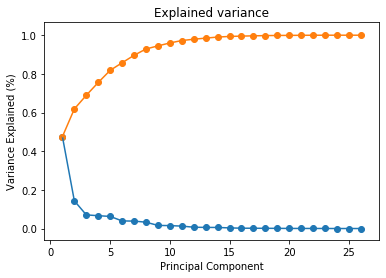

In [8]:
# Fit PCA model and assess:
pca = PCA()
pca.fit(weather_pca)

# Plot the explained_variance_ratio_
x_values = list(range(1, pca.n_components_+1))
plt.plot(x_values, pca.explained_variance_ratio_)
plt.scatter(x_values, pca.explained_variance_ratio_)
plt.plot(x_values, np.cumsum(pca.explained_variance_ratio_))
plt.scatter(x_values, np.cumsum(pca.explained_variance_ratio_))
plt.title('Explained variance')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained (%)')
plt.show()

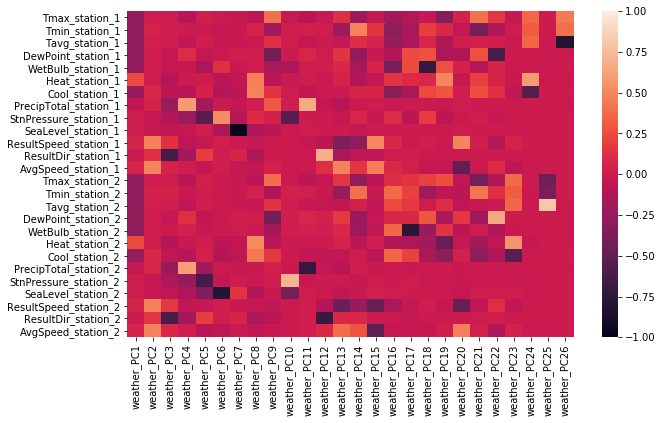

In [9]:
weather_dict = {'weather_PC'+str(i+1): pca.components_[i] for i in range(len(pca.components_))}
weather_pca_df = pd.DataFrame(weather_dict, index=weather_pca.columns)

weather_pcs = pd.DataFrame(pca.transform(weather_pca),
                           columns=['weather_PC'+str(i+1) for i in range(len(weather_pca.columns))],
                           index=weather_df.index)
plt.figure(figsize=(10,6))
sns.heatmap(weather_pca_df, vmin=-1, vmax=1);

### Spray Data

The City of Chicago also does spraying to kill mosquitos. We are given the GIS data for their spray efforts
in 2011 and 2013. Spraying can reduce the number of mosquitos in the area, and therefore might eliminate the appearance of West Nile virus.

In [10]:
spray = pd.read_csv('./datasets/spray.csv')
spray['Time'] = spray['Time'].fillna(value=spray.mode().Time[0])
spray['DateTime'] = spray.apply(lambda x: str(x['Date'])+' '+str(x['Time']), axis=1)
spray['DateTime'] = spray.apply(lambda x: datetime.strptime(str(x['DateTime']), '%Y-%m-%d %I:%M:%S %p'), axis=1)
spray['Date'] = spray.apply(lambda x: datetime.strptime(str(x['Date']), '%Y-%m-%d'), axis=1)
spray['Latitude2'] = np.round(spray.Latitude,2)
spray['Longitude2'] = np.round(spray.Longitude,2)
spray.set_index('DateTime', inplace=True, drop=True)
spray_df = spray.drop_duplicates(subset=['Date','Latitude2','Longitude2'])

## EDA: visualise and analyse data

### Prepare train, test dataframes

In [11]:
# Merging weather data onto train,test data:
train_df = train.merge(weather_df, how='left', on='Date', suffixes=('',''))
test_df = test.merge(weather_df, how='left', on='Date', suffixes=('',''))
# Merging weather_pcs data onto train,test data:
train_df = train_df.merge(weather_pcs, how='left', on='Date', suffixes=('',''))
test_df = test_df.merge(weather_pcs, how='left', on='Date', suffixes=('',''))
# Merging spray data onto train,test data:
    # Creating approx. lat,lon co-ordinates to match spray_df
train_df['Latitude2'] = np.round(train_df.Latitude,2)
train_df['Longitude2'] = np.round(train_df.Longitude,2)
test_df['Latitude2'] = np.round(test_df.Latitude,2)
test_df['Longitude2'] = np.round(test_df.Longitude,2)
    # Merge with spray_df
train_df = train_df.merge(spray_df, how='left', on=['Date','Latitude2','Longitude2'], suffixes=('','_spray'))
train_df['isSpray'] = [0 if x==0 else 1 for x in train_df.Time.fillna(value=0)]
train_df.set_index('Date', inplace=True, drop=True)
test_df = test_df.merge(spray_df, how='left', on=['Date','Latitude2','Longitude2'], suffixes=('','_spray'))
test_df['isSpray'] = [0 if x==0 else 1 for x in test_df.Time.fillna(value=0)]
test_df.set_index('Date', inplace=True, drop=True)

In [12]:
train_df.head(1)

,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent,Station_station_1,Latitude_station_1,Longitude_station_1,Tmax_station_1,Tmin_station_1,Tavg_station_1,Depart_station_1,DewPoint_station_1,WetBulb_station_1,Heat_station_1,Cool_station_1,Sunrise_station_1,Sunset_station_1,CodeSum_station_1,Depth_station_1,Water1_station_1,SnowFall_station_1,PrecipTotal_station_1,StnPressure_station_1,SeaLevel_station_1,ResultSpeed_station_1,ResultDir_station_1,AvgSpeed_station_1,Station_station_2,Latitude_station_2,Longitude_station_2,Tmax_station_2,Tmin_station_2,Tavg_station_2,Depart_station_2,DewPoint_station_2,WetBulb_station_2,Heat_station_2,Cool_station_2,Sunrise_station_2,Sunset_station_2,CodeSum_station_2,Depth_station_2,Water1_station_2,SnowFall_station_2,PrecipTotal_station_2,StnPressure_station_2,SeaLevel_station_2,ResultSpeed_station_2,ResultDir_station_2,AvgSpeed_station_2,weather_PC1,weather_PC2,weather_PC3,weather_PC4,weather_PC5,weather_PC6,weather_PC7,weather_PC8,weather_PC9,weather_PC10,weather_PC11,weather_PC12,weather_PC13,weather_PC14,weather_PC15,weather_PC16,weather_PC17,weather_PC18,weather_PC19,weather_PC20,weather_PC21,weather_PC22,weather_PC23,weather_PC24,weather_PC25,weather_PC26,Latitude2,Longitude2,Time,Latitude_spray,Longitude_spray,isSpray
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,1,0,1,41.995,-87.933,88,60,74.0,10,58,65,0,9,0421,1917,BR HZ,0,M,0.0,0.0,29.39,30.11,5.8,18,6.5,2,41.786,-87.752,88,65,76.5,M,59,66,0,12,-,-,BR HZ,M,M,M,0.0,29.44,30.09,5.8,16,7.4,-2.597497,-0.583877,0.097459,-0.756588,-0.023922,-0.100406,-0.173416,0.145576,0.464665,-0.045627,-0.089957,0.02089,-0.019865,-0.354337,-0.243011,0.184774,0.03629,-0.081355,-0.096362,0.150023,-0.01562,0.024673,0.003364,0.021722,2.047035e-17,5.391743e-16,41.95,-87.8,NaN,NaN,NaN,0


### Time-shifted weather feature analysis:
Research suggests that increased air temperature was the strongest temporal predictor of increased infection in Culex mosquitoes, with cumulative high temperature differences being a key factor distinguishing years
with higher mosquito infection and higher human illness rates from those with lower rates. Drier conditions in the spring followed by wetter conditions just prior to an increase in infection were factors in some but not all years. Overall, 80% of the weekly variation in mosquito infection was explained by prior weather conditions.

Based on correlation matrix we will assess which lagged weather feature could improve our model.

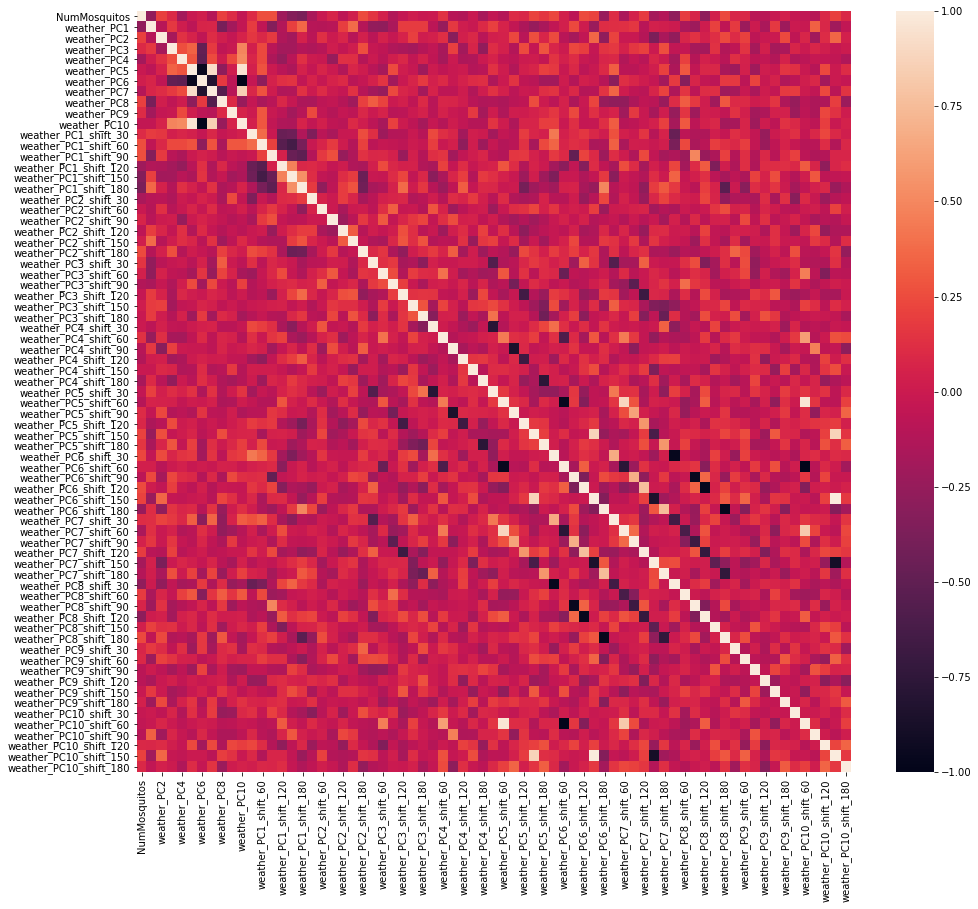

In [42]:
# Creating dataframe containing weather features at different lags:
weather_shifted = weather_pcs[['weather_PC1','weather_PC2','weather_PC3','weather_PC4','weather_PC5',
                               'weather_PC6','weather_PC7','weather_PC8','weather_PC9','weather_PC10']].copy()

weather_features = ['weather_PC1','weather_PC2','weather_PC3','weather_PC4','weather_PC5',
                    'weather_PC6','weather_PC7','weather_PC8','weather_PC9','weather_PC10']
time_shifts = [30,60,90,120,150,180]

for pc in weather_features:
    for i in time_shifts:
        weather_shifted['{}_shift_{}'.format(pc,i)] = weather_shifted['{}'.format(pc)].shift(i)

mosquitoes = train_df[['NumMosquitos']].groupby('Date').mean()
weather_shifted = mosquitoes.merge(weather_shifted, how='left', left_on='Date', right_on='Date')

# Visualising correlations as a heatmap:
plt.figure(figsize=(16,14))
sns.heatmap(weather_shifted.iloc[33:,:].corr(), vmin=-1, vmax=1);

Shifting each weather by up to 6 months didn't highlight large correlations for with NumMosquitos, in that case I will proceed with unshifted weather features

### Scatter plots
Visualising the data shows that incidence of the virus was concentrated in August, and also that a handful of Traps recorded far higher incidences

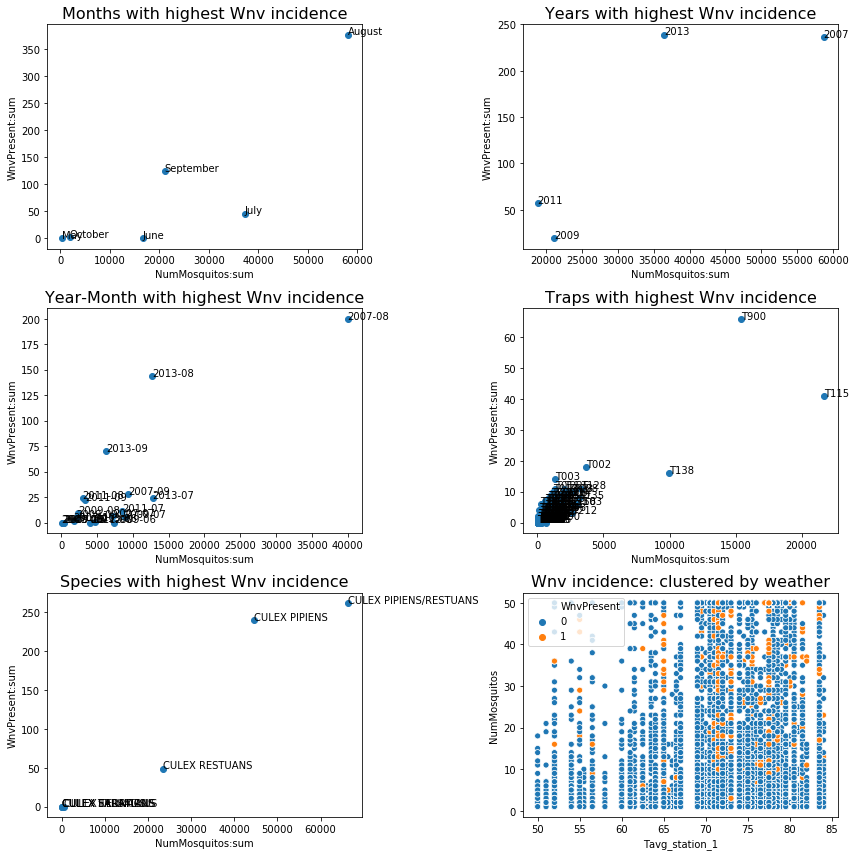

In [14]:
train_month_grp = train.groupby(train.index.month_name()).agg({'WnvPresent':'sum',
                                                        'NumMosquitos': 'sum'}).sort_values('WnvPresent',
                                                                                            ascending=False)
train_year_grp = train.groupby(train.index.year).agg({'WnvPresent':'sum',
                                                      'NumMosquitos': 'sum'}).sort_values('WnvPresent',
                                                                                          ascending=False)
train_monthyear_grp = train.groupby(train.index.to_period('M')).agg({'WnvPresent':'sum',
                                                                     'NumMosquitos': 'sum'}).sort_values('WnvPresent',
                                                                                                         ascending=False)
train_trap_grp = train.groupby('Trap').agg({'WnvPresent':'sum',
                                            'NumMosquitos': 'sum'}).sort_values('WnvPresent',
                                                                                ascending=False)
train_species_grp = train.groupby('Species').agg({'WnvPresent':'sum',
                                                  'NumMosquitos': 'sum'}).sort_values('WnvPresent',
                                                                                      ascending=False)
# Scatter-plot both sets of data:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(12,12))
ax[0,0].scatter(train_month_grp['NumMosquitos'], train_month_grp['WnvPresent']);
for i, xi in enumerate(train_month_grp.index):
    ax[0,0].annotate(xi, (train_month_grp.iloc[i,1], train_month_grp.iloc[i,0]))
ax[0,0].set_xlabel('NumMosquitos:sum', fontsize=10)
ax[0,0].set_ylabel('WnvPresent:sum', fontsize=10)
ax[0,0].set_title('Months with highest Wnv incidence', fontsize=16)

ax[0,1].scatter(train_year_grp['NumMosquitos'], train_year_grp['WnvPresent']);
for i, xi in enumerate(train_year_grp.index):
    ax[0,1].annotate(xi, (train_year_grp.iloc[i,1], train_year_grp.iloc[i,0]))
ax[0,1].set_xlabel('NumMosquitos:sum', fontsize=10)
ax[0,1].set_ylabel('WnvPresent:sum', fontsize=10)
ax[0,1].set_title('Years with highest Wnv incidence', fontsize=16)

ax[1,0].scatter(train_monthyear_grp['NumMosquitos'], train_monthyear_grp['WnvPresent']);
for i, xi in enumerate(train_monthyear_grp.index):
    ax[1,0].annotate(xi, (train_monthyear_grp.iloc[i,1], train_monthyear_grp.iloc[i,0]))
ax[1,0].set_xlabel('NumMosquitos:sum', fontsize=10)
ax[1,0].set_ylabel('WnvPresent:sum', fontsize=10)
ax[1,0].set_title('Year-Month with highest Wnv incidence', fontsize=16)

ax[1,1].scatter(train_trap_grp['NumMosquitos'], train_trap_grp['WnvPresent']);
for i, xi in enumerate(train_trap_grp.index):
    ax[1,1].annotate(xi, (train_trap_grp.iloc[i,1], train_trap_grp.iloc[i,0]))
ax[1,1].set_xlabel('NumMosquitos:sum', fontsize=10)
ax[1,1].set_ylabel('WnvPresent:sum', fontsize=10)
ax[1,1].set_title('Traps with highest Wnv incidence', fontsize=16)

ax[2,0].scatter(train_species_grp['NumMosquitos'], train_species_grp['WnvPresent']);
for i, xi in enumerate(train_species_grp.index):
    ax[2,0].annotate(xi, (train_species_grp.iloc[i,1], train_species_grp.iloc[i,0]))
ax[2,0].set_xlabel('NumMosquitos:sum', fontsize=10)
ax[2,0].set_ylabel('WnvPresent:sum', fontsize=10)
ax[2,0].set_title('Species with highest Wnv incidence', fontsize=16)

sns.scatterplot(train_df['Tavg_station_1'], train_df['NumMosquitos'], hue=train_df['WnvPresent'], ax=ax[2,1]);
ax[2,1].set_xlabel('Tavg_station_1', fontsize=10)
ax[2,1].set_ylabel('NumMosquitos', fontsize=10)
ax[2,1].set_title('Wnv incidence: clustered by weather', fontsize=16)

plt.tight_layout()
plt.show();

# Clear to see that both Wnv and NumMosquitos was highest in certain Traps, years, and months.

## Modelling

#### Setting up (X, y)

In [13]:
y, X = train_df['WnvPresent'], train_df[['Species','Trap','weather_PC1','weather_PC2','weather_PC3','weather_PC4',
                                         'weather_PC5','weather_PC6','weather_PC7','weather_PC8',
                                         'weather_PC9','weather_PC10','isSpray']]

X_dum = pd.get_dummies(X, drop_first=True, columns=['Species','Trap'])

# instantiate pre-processing:
std = StandardScaler()
ovr = RandomOverSampler()
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

### Sci-kit Learn GridSearchCV tuning classifiers
- Now we will optimise and compare how well different classification methods predict for the time and location of the virus
- Note: the classifiers have already been run in the first iteration, here I reload the best models that I had pickled and present their findings:

#### Load Pickled Models

In [41]:
Tk().withdraw()
pipe_lr_best = pickle.load(open(askopenfilename(), 'rb'))
pipe_lrcv_best = pickle.load(open(askopenfilename(), 'rb'))
pipe_dt_best = pickle.load(open(askopenfilename(), 'rb'))
pipe_rf_best = pickle.load(open(askopenfilename(), 'rb'))
pipe_bc_best = pickle.load(open(askopenfilename(), 'rb'))
pipe_gb_best = pickle.load(open(askopenfilename(), 'rb'))
pipe_xgb_best = pickle.load(open(askopenfilename(), 'rb'))
Tk().destroy()

#### Logistic Regression

In [39]:
lrcv = LogisticRegressionCV(fit_intercept=False, class_weight='balanced', max_iter=10000, scoring='roc_auc')
lrcv.fit(X_dum, y)
print(lrcv.score(X_dum,y))
print(lrcv.C_)

0.7859392675387702
[0.35938137]


##### Logistic Regression Results

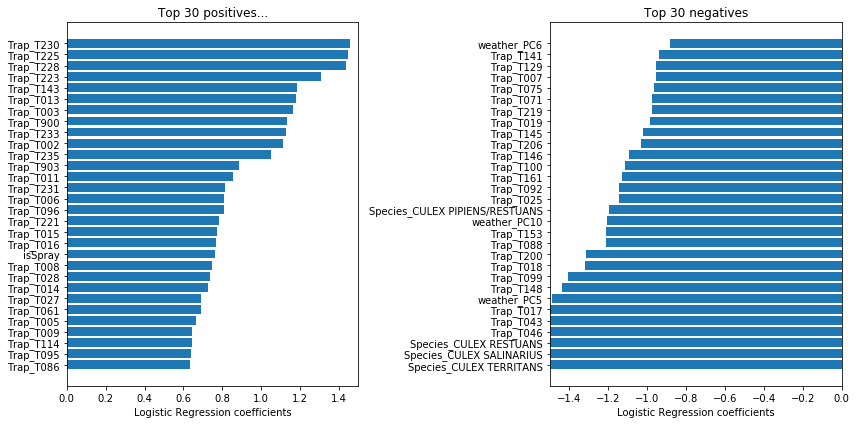

In [68]:
lrcv_coefficients = pd.DataFrame(lrcv.coef_,
                                 columns=X_dum.columns,
                                 index=['coefficients']).T.sort_values('coefficients',ascending=True)

fig, ax = plt.subplots(ncols=2, figsize=(12,6))
ax[0].barh(lrcv_coefficients.iloc[-30:,0].index, lrcv_coefficients.iloc[-30:,0])
ax[0].set_title('Top 30 positives...')
ax[0].set_xlabel('Logistic Regression coefficients')
ax[0].set_xlim([0,1.5])
ax[1].barh(lrcv_coefficients.iloc[:30,0].index, lrcv_coefficients.iloc[:30,0])
ax[1].set_title('Top 30 negatives')
ax[1].set_xlabel('Logistic Regression coefficients')
ax[1].set_xlim([-1.5,0])
fig.tight_layout();

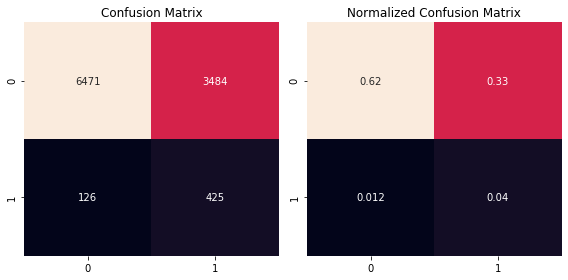

In [69]:
# Visualise confusion matrix:
cm = confusion_matrix(y, lrcv.predict(X_dum))
cm_norm = confusion_matrix(y, lrcv.predict(X_dum), normalize='all')
classes = lrcv.classes_

fig, ax = plt.subplots(ncols=2, figsize=(8,4))
sns.heatmap(pd.DataFrame(cm, index=classes, columns=classes), annot=True, fmt='d', cbar=False, ax=ax[0])
ax[0].set_title('Confusion Matrix')
sns.heatmap(pd.DataFrame(cm_norm, index=classes, columns=classes), annot=True, cbar=False, ax=ax[1])
ax[1].set_title('Normalized Confusion Matrix')

plt.tight_layout();

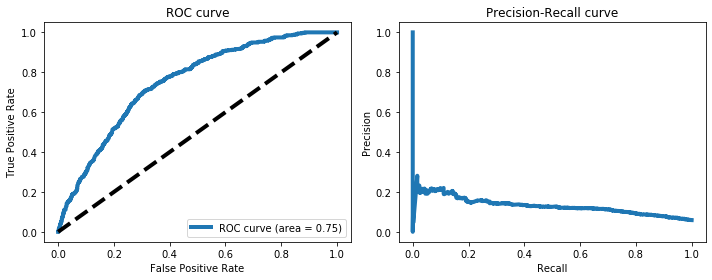

In [53]:
y_pp = pd.DataFrame(lrcv.predict_proba(X_dum), columns=['class_0_pp', 'class_1_pp'])

# ROC curve
fpr, tpr, threshold = roc_curve(y, y_pp.class_1_pp)
roc_auc = auc(fpr, tpr)

fig, ax = plt.subplots(ncols=2, figsize=(10,4))
ax[0].plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc, linewidth=4)
ax[0].plot([0, 1], [0, 1], 'k--', linewidth=4)
ax[0].set_xlabel('False Positive Rate')
ax[0].set_ylabel('True Positive Rate')
ax[0].legend(loc="lower right")
ax[0].set_title('ROC curve')

# PR curve
precision, recall, threshold = precision_recall_curve(y, y_pp.class_1_pp)

ax[1].plot(recall, precision, label='Precision-recall curve', linewidth=4)
ax[1].set_xlabel('Recall')
ax[1].set_ylabel('Precision')
ax[1].set_title('Precision-Recall curve')

plt.tight_layout();

In [40]:
# Pickle if results are satisfactory:
gs_lrcv_pickle_name = './pickle_objects/gs_lrcv_best_score_{}%.pkl'.format(np.round(lrcv.score(X_dum,y)*100,2))
pickle.dump(lrcv, open(gs_lrcv_pickle_name, 'wb'))

#### Decision Tree Classifier

In [ ]:
dt = DecisionTreeClassifier()
params = {'dt__max_depth':range(2,10),
          'dt__max_features':np.linspace(0.1,0.5,4)}

pipeline = Pipeline([('ovr', ovr), ('dt', dt)])

gs_dt = GridSearchCV(pipeline, params, verbose=1, n_jobs=2, cv=kf, scoring='roc_auc')
gs_dt.fit(X_dum, y)
print(gs_dt.best_params_)
print(gs_dt.best_score_)

##### Decision Tree Results

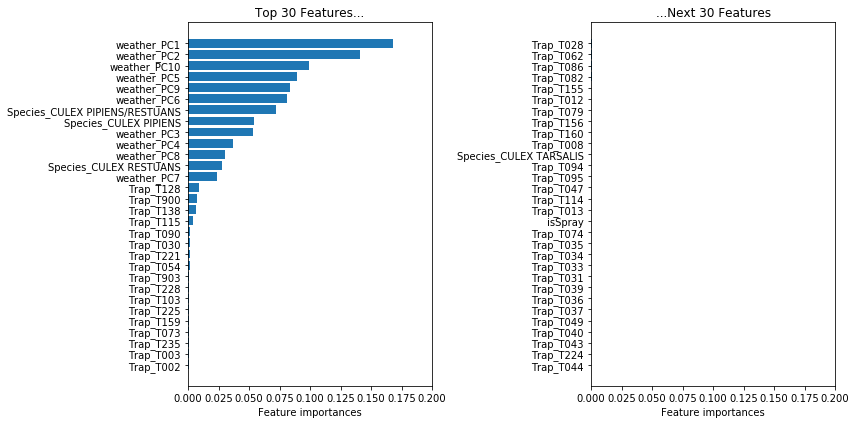

In [65]:
pipe_dt_best.fit(X_dum, y)
gs_dt_importances = pd.DataFrame(pipe_dt_best.steps[1][1].feature_importances_,
                                 index=X_dum.columns,
                                 columns=['importances']).sort_values('importances', ascending=True)

fig, ax = plt.subplots(ncols=2, figsize=(12,6))
ax[0].barh(gs_dt_importances.iloc[-30:,0].index, gs_dt_importances.iloc[-30:,0])
ax[0].set_title('Top 30 Features...')
ax[0].set_xlabel('Feature importances')
ax[0].set_xlim([0,0.2])
ax[1].barh(gs_dt_importances.iloc[-60:,:].iloc[:30,0].index, gs_dt_importances.iloc[-60:,:].iloc[:30,0])
ax[1].set_title('...Next 30 Features')
ax[1].set_xlabel('Feature importances')
ax[1].set_xlim([0,0.2])
fig.tight_layout();

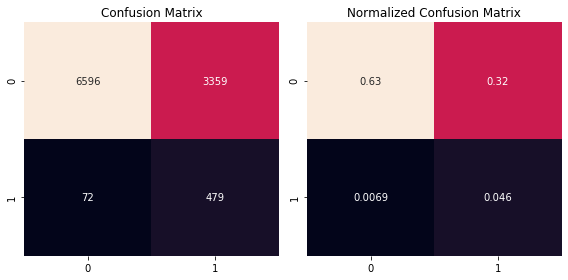

In [66]:
# Visualise confusion matrix:
cm = confusion_matrix(y, pipe_dt_best.predict(X_dum))
cm_norm = confusion_matrix(y, pipe_dt_best.predict(X_dum), normalize='all')
classes = pipe_dt_best.classes_

fig, ax = plt.subplots(ncols=2, figsize=(8,4))
sns.heatmap(pd.DataFrame(cm, index=classes, columns=classes), annot=True, fmt='d', cbar=False, ax=ax[0])
ax[0].set_title('Confusion Matrix')
sns.heatmap(pd.DataFrame(cm_norm, index=classes, columns=classes), annot=True, cbar=False, ax=ax[1])
ax[1].set_title('Normalized Confusion Matrix')

plt.tight_layout();

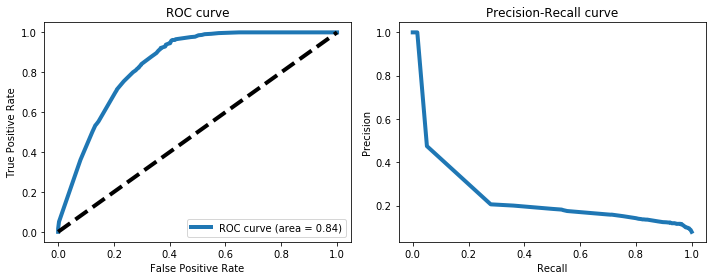

In [74]:
y_pp = pd.DataFrame(pipe_dt_best.predict_proba(X_dum), columns=['class_0_pp', 'class_1_pp'])

# ROC curve
fpr, tpr, threshold = roc_curve(y, y_pp.class_1_pp)
roc_auc = auc(fpr, tpr)

fig, ax = plt.subplots(ncols=2, figsize=(10,4))
ax[0].plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc, linewidth=4)
ax[0].plot([0, 1], [0, 1], 'k--', linewidth=4)
ax[0].set_xlabel('False Positive Rate')
ax[0].set_ylabel('True Positive Rate')
ax[0].legend(loc="lower right")
ax[0].set_title('ROC curve')

# PR curve
precision, recall, threshold = precision_recall_curve(y, y_pp.class_1_pp)

ax[1].plot(recall, precision, label='Precision-recall curve', linewidth=4)
ax[1].set_xlabel('Recall')
ax[1].set_ylabel('Precision')
ax[1].set_title('Precision-Recall curve')

plt.tight_layout();

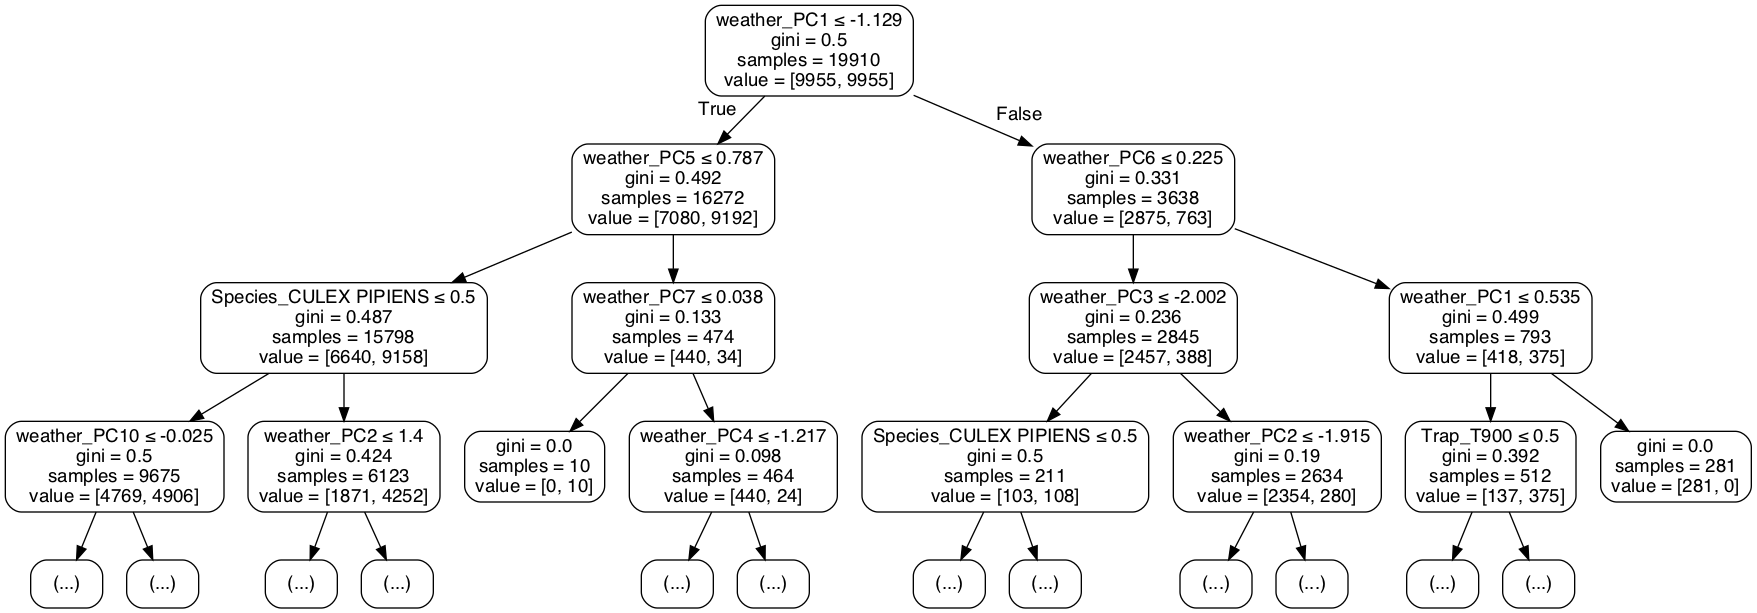

In [76]:
# Visualise Decision Tree
dot_data = StringIO() 
export_graphviz(pipe_dt_best.steps[1][1], out_file=dot_data, rounded=True,
                special_characters=True,
                feature_names=X_dum.columns,
                max_depth=3)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

As seen above with the feature_importances_ chart, the weather features dominate as the most important features. There are too many trap features for each one to appear as an important feature. This model will behave poorly in predicting location of the virus

In [ ]:
# Pickle if results are satisfactory:
gs_dt_pickle_name = './pickle_objects/gs_dt_best_score_{}%.pkl'.format(np.round(gs_dt.best_score_*100,2))
pickle.dump(gs_dt.best_estimator_, open(gs_dt_pickle_name, 'wb'))

#### Bagging Classifier

In [23]:
bc = BaggingClassifier(n_estimators=100, oob_score=True)
params = {'bc__max_samples': np.linspace(0.1, 1, 5),
          'bc__max_features':list(range(8,16))}

pipeline = Pipeline([('std', std), ('ovr', ovr), ('bc', bc)])

gs_bc = GridSearchCV(pipeline, params, verbose=1, n_jobs=2, cv=kf, scoring='roc_auc')
gs_bc.fit(X_dum, y)
print(gs_bc.best_params_)
print(gs_bc.best_score_)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  1.1min
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:  4.9min
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:  5.0min finished


{'bc__max_features': 10, 'bc__max_samples': 1.0}
0.8324657066545564


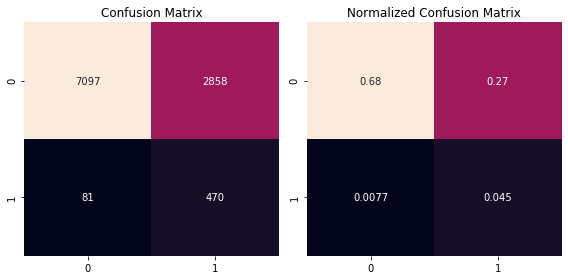

In [27]:
# Visualise confusion matrix:
cm = confusion_matrix(y, pipe_bc_best.predict(X_dum))
cm_norm = confusion_matrix(y, pipe_bc_best.predict(X_dum), normalize='all')
classes = pipe_bc_best.classes_

fig, ax = plt.subplots(ncols=2, figsize=(8,4))
sns.heatmap(pd.DataFrame(cm, index=classes, columns=classes), annot=True, fmt='d', cbar=False, ax=ax[0])
ax[0].set_title('Confusion Matrix')
sns.heatmap(pd.DataFrame(cm_norm, index=classes, columns=classes), annot=True, cbar=False, ax=ax[1])
ax[1].set_title('Normalized Confusion Matrix')

plt.tight_layout();

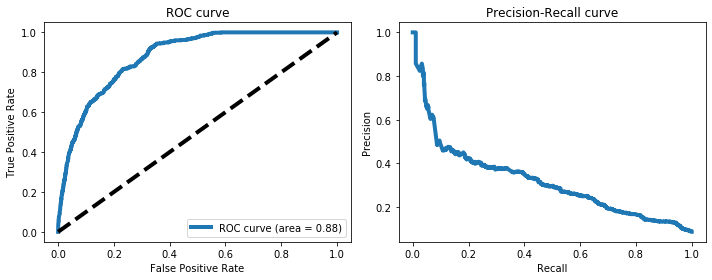

In [28]:
y_pp = pd.DataFrame(pipe_bc_best.predict_proba(X_dum), columns=['class_0_pp', 'class_1_pp'])

# ROC curve
fpr, tpr, threshold = roc_curve(y, y_pp.class_1_pp)
roc_auc = auc(fpr, tpr)

fig, ax = plt.subplots(ncols=2, figsize=(10,4))
ax[0].plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc, linewidth=4)
ax[0].plot([0, 1], [0, 1], 'k--', linewidth=4)
ax[0].set_xlabel('False Positive Rate')
ax[0].set_ylabel('True Positive Rate')
ax[0].legend(loc="lower right")
ax[0].set_title('ROC curve')

# PR curve
precision, recall, threshold = precision_recall_curve(y, y_pp.class_1_pp)

ax[1].plot(recall, precision, label='Precision-recall curve', linewidth=4)
ax[1].set_xlabel('Recall')
ax[1].set_ylabel('Precision')
ax[1].set_title('Precision-Recall curve')

plt.tight_layout();

In [16]:
# Pickle if results are satisfactory:
gs_bc_pickle_name = './pickle_objects/gs_bc_best_score_{}%.pkl'.format(np.round(gs_bc.best_score_*100,2))
pickle.dump(gs_bc.best_estimator_, open(gs_bc_pickle_name, 'wb'))

#### Random Forest Classifier

In [15]:
rf = RandomForestClassifier(n_estimators=100, oob_score=True)
params = {'rf__max_depth': list(range(2,10))+[None],
          'rf__max_features':list(range(8,16))}

pipeline = Pipeline([('ovr', ovr), ('rf', rf)])

gs_rf = GridSearchCV(pipeline, params, verbose=1, n_jobs=2, cv=kf, scoring='roc_auc')
gs_rf.fit(X_dum, y)
print(gs_rf.best_params_)
print(gs_rf.best_score_)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  1.2min
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:  4.1min
[Parallel(n_jobs=2)]: Done 360 out of 360 | elapsed:  8.3min finished


{'rf__max_depth': 9, 'rf__max_features': 14}
0.8220128292303078


In [39]:
Tk().withdraw()
pipe_rf_best = pickle.load(open(askopenfilename(), 'rb'))
Tk().destroy()

In [41]:
rf = RandomForestClassifier(n_estimators=1000, oob_score=True, warm_start=True)
params = {'rf__max_depth':[9],
          'rf__max_features':[14]}

pipeline = Pipeline([('ovr', ovr), ('rf', rf)])

gs_rf = GridSearchCV(pipeline, params, verbose=1, n_jobs=2, cv=kf, scoring='roc_auc')
gs_rf.fit(X_dum, y)
print(gs_rf.best_params_)
print(gs_rf.best_score_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  1.2min finished


{'rf__max_depth': 9, 'rf__max_features': 14}
0.766789409838129


##### Random Forest Results

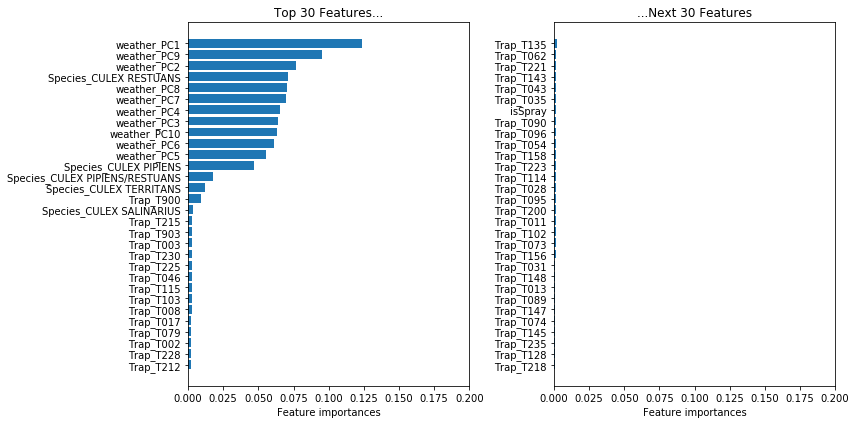

In [20]:
fig, ax = plt.subplots(ncols=2, figsize=(12,6))
gs_rf_importances = pd.DataFrame(pipe_rf_best.steps[1][1].feature_importances_,
                                 index=X_dum.columns,
                                 columns=['importances']).sort_values('importances',ascending=True)
ax[0].barh(gs_rf_importances.iloc[-30:,0].index, gs_rf_importances.iloc[-30:,0])
ax[0].set_title('Top 30 Features...')
ax[0].set_xlabel('Feature importances')
ax[0].set_xlim([0,0.2])
ax[1].barh(gs_rf_importances.iloc[-60:,:].iloc[:30,0].index, gs_rf_importances.iloc[-60:,:].iloc[:30,0])
ax[1].set_title('...Next 30 Features')
ax[1].set_xlabel('Feature importances')
ax[1].set_xlim([0,0.2])
fig.tight_layout();

The Random Forest classifier suffers the same issue as the Decision Tree and Bagging - even if we randomize feature selection, it's the weather features that are most important, ie. that reduce the 'gini' loss function most.

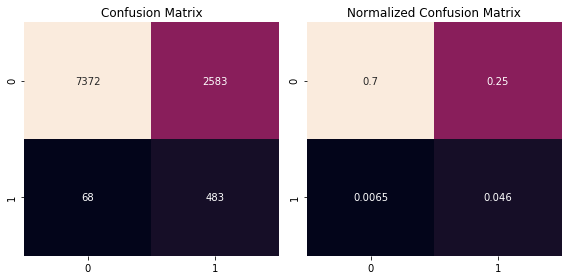

In [21]:
# Visualise confusion matrix:
cm = confusion_matrix(y, pipe_rf_best.predict(X_dum))
cm_norm = confusion_matrix(y, pipe_rf_best.predict(X_dum), normalize='all')
classes = pipe_rf_best.classes_

fig, ax = plt.subplots(ncols=2, figsize=(8,4))
sns.heatmap(pd.DataFrame(cm, index=classes, columns=classes), annot=True, fmt='d', cbar=False, ax=ax[0])
ax[0].set_title('Confusion Matrix')
sns.heatmap(pd.DataFrame(cm_norm, index=classes, columns=classes), annot=True, cbar=False, ax=ax[1])
ax[1].set_title('Normalized Confusion Matrix')

plt.tight_layout();

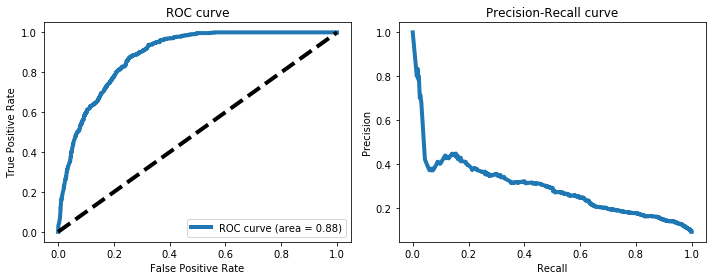

In [22]:
y_pp = pd.DataFrame(pipe_rf_best.predict_proba(X_dum), columns=['class_0_pp', 'class_1_pp'])

# ROC curve
fpr, tpr, threshold = roc_curve(y, y_pp.class_1_pp)
roc_auc = auc(fpr, tpr)

fig, ax = plt.subplots(ncols=2, figsize=(10,4))
ax[0].plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc, linewidth=4)
ax[0].plot([0, 1], [0, 1], 'k--', linewidth=4)
ax[0].set_xlabel('False Positive Rate')
ax[0].set_ylabel('True Positive Rate')
ax[0].legend(loc="lower right")
ax[0].set_title('ROC curve')

# PR curve
precision, recall, threshold = precision_recall_curve(y, y_pp.class_1_pp)

ax[1].plot(recall, precision, label='Precision-recall curve', linewidth=4)
ax[1].set_xlabel('Recall')
ax[1].set_ylabel('Precision')
ax[1].set_title('Precision-Recall curve')

plt.tight_layout();

In [38]:
# Pickle if results are satisfactory:
gs_rf_pickle_name = './pickle_objects/gs_rf_best_score_{}%.pkl'.format(np.round(gs_rf.best_score_*100,2))
pickle.dump(gs_rf.best_estimator_, open(gs_rf_pickle_name, 'wb'))

#### Gradient Boosting Classifier

In [32]:
gb = GradientBoostingClassifier(n_estimators=1000, n_iter_no_change=20)
params = {'gb__learning_rate': np.linspace(.01,0.1,4),
          'gb__max_depth':list(range(2,5)),
          'gb__max_features':list(range(8,16))}

pipeline = Pipeline([('ovr', ovr), ('gb', gb)])

gs_gb = GridSearchCV(pipeline, params, verbose=1, n_jobs=2, cv=kf, scoring='roc_auc')
gs_gb.fit(X_dum, y)
print(gs_gb.best_params_)
print(gs_gb.best_score_)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  4.3min
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed: 131.8min
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed: 224.6min
[Parallel(n_jobs=2)]: Done 480 out of 480 | elapsed: 230.5min finished


{'gb__learning_rate': 0.07, 'gb__max_depth': 3, 'gb__max_features': 14}
0.8374556018051749


##### Gradient Boosting Results

In [46]:
Tk().withdraw()
pipe_gb_best = pickle.load(open(askopenfilename(), 'rb'))
Tk().destroy()

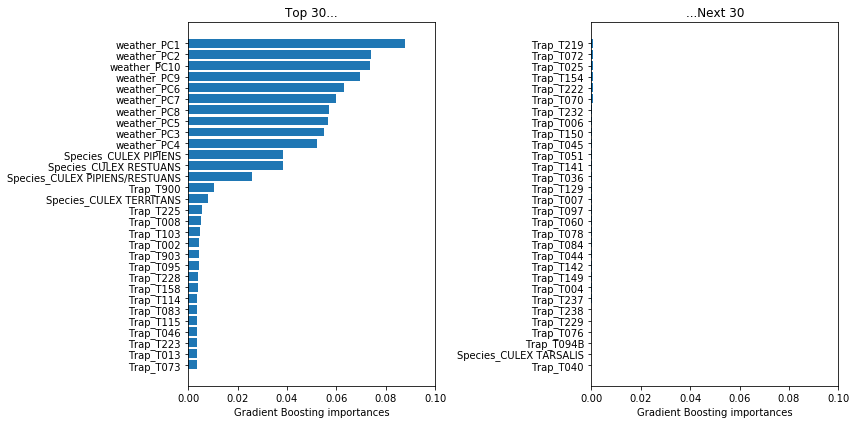

In [47]:
pipe_gb_best.fit(X_dum, y)
gb_feature_importances = pd.DataFrame(pipe_gb_best.steps[1][1].feature_importances_,
                                      index=X_dum.columns,
                                      columns=['importances']).sort_values('importances')

fig, ax = plt.subplots(ncols=2, figsize=(12,6))
ax[0].barh(gb_feature_importances.iloc[-30:,0].index, gb_feature_importances.iloc[-30:,0])
ax[0].set_title('Top 30...')
ax[0].set_xlabel('Gradient Boosting importances')
ax[0].set_xlim([0,0.1])
ax[1].barh(gb_feature_importances.iloc[:30,0].index, gb_feature_importances.iloc[:30,0])
ax[1].set_title('...Next 30')
ax[1].set_xlabel('Gradient Boosting importances')
ax[1].set_xlim([0,0.1])
fig.tight_layout();

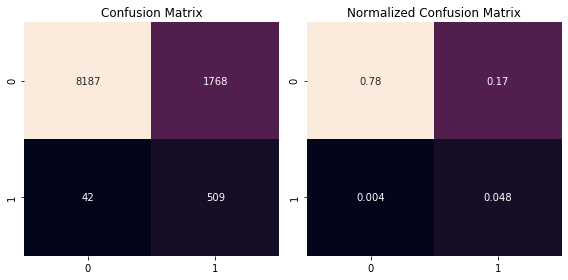

In [36]:
# Visualise confusion matrix:
cm = confusion_matrix(y, pipe_gb_best.predict(X_dum))
cm_norm = confusion_matrix(y, pipe_gb_best.predict(X_dum), normalize='all')
classes = pipe_gb_best.classes_

fig, ax = plt.subplots(ncols=2, figsize=(8,4))
sns.heatmap(pd.DataFrame(cm, index=classes, columns=classes), annot=True, fmt='d', cbar=False, ax=ax[0])
ax[0].set_title('Confusion Matrix')
sns.heatmap(pd.DataFrame(cm_norm, index=classes, columns=classes), annot=True, cbar=False, ax=ax[1])
ax[1].set_title('Normalized Confusion Matrix')

plt.tight_layout();

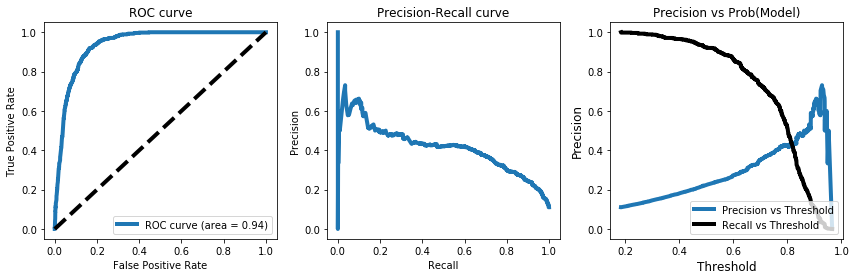

In [37]:
y_pp = pd.DataFrame(pipe_gb_best.predict_proba(X_dum), columns=['class_0_pp', 'class_1_pp'])

# ROC curve
fpr, tpr, threshold = roc_curve(y, y_pp.class_1_pp)
roc_auc = auc(fpr, tpr)

fig, ax = plt.subplots(ncols=3, figsize=(12,4))
ax[0].plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc, linewidth=4)
ax[0].plot([0, 1], [0, 1], 'k--', linewidth=4)
ax[0].set_xlabel('False Positive Rate')
ax[0].set_ylabel('True Positive Rate')
ax[0].legend(loc="lower right")
ax[0].set_title('ROC curve')

# PR curve
precision, recall, threshold = precision_recall_curve(y, y_pp.class_1_pp)

ax[1].plot(recall, precision, label='Precision-recall curve', linewidth=4)
ax[1].set_xlabel('Recall')
ax[1].set_ylabel('Precision')
ax[1].set_title('Precision-Recall curve')

# Threshold Tuning chart
ax[2].plot(threshold, precision[:-1], label='Precision vs Threshold', linewidth=4)
ax[2].plot(threshold, recall[:-1], label='Recall vs Threshold', c='k', linewidth=4)
ax[2].set_xlabel('Threshold', fontsize=12)
ax[2].set_ylabel('Precision', fontsize=12)
ax[2].set_title('Precision vs Prob(Model)', fontsize=12)
plt.legend(loc="lower right")

plt.tight_layout();

In [30]:
# Pickle if results are satisfactory:
gs_gb_pickle_name = './pickle_objects/gs_gb_best_score_{}%.pkl'.format(np.round(gs_gb.best_score_*100,2))
pickle.dump(gs_gb.best_estimator_, open(gs_gb_pickle_name, 'wb'))

#### XGBoost Classifier

In [19]:
xgb = XGBClassifier(n_estimators=1000)
params = {'xgb__learning_rate':[0.07],
          'xgb__max_depth':[14]}

pipeline = Pipeline([('ovr', ovr), ('xgb', xgb)])

gs_xgb = GridSearchCV(pipeline, params, verbose=1, n_jobs=2, cv=kf, scoring='roc_auc')
gs_xgb.fit(X_dum, y)
print(gs_xgb.best_params_)
print(gs_xgb.best_score_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed: 23.4min finished


{'xgb__learning_rate': 0.07, 'xgb__max_depth': 14}
0.8124661180060478


##### XGBoost Results

In [22]:
Tk().withdraw()
pipe_xgb_best = pickle.load(open(askopenfilename(), 'rb'))
Tk().destroy()

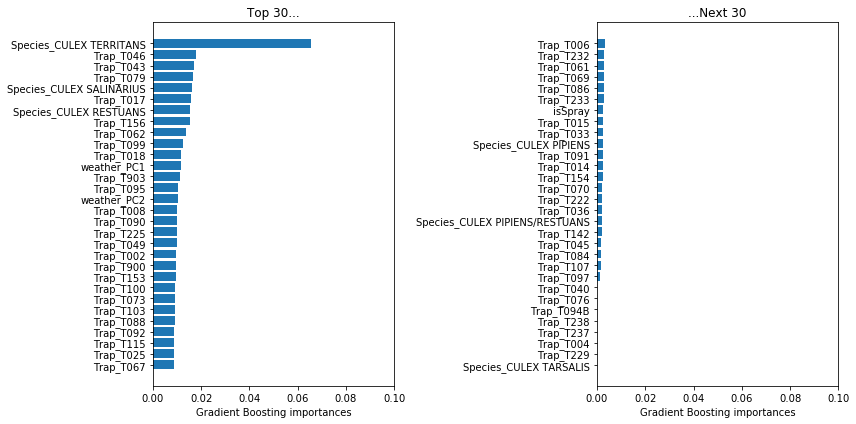

In [25]:
pipe_xgb_best.fit(X_dum, y)
xgb_feature_importances = pd.DataFrame(pipe_xgb_best.steps[1][1].feature_importances_,
                                      index=X_dum.columns,
                                      columns=['importances']).sort_values('importances')

fig, ax = plt.subplots(ncols=2, figsize=(12,6))
ax[0].barh(xgb_feature_importances.iloc[-30:,0].index, xgb_feature_importances.iloc[-30:,0])
ax[0].set_title('Top 30...')
ax[0].set_xlabel('Gradient Boosting importances')
ax[0].set_xlim([0,0.1])
ax[1].barh(xgb_feature_importances.iloc[:30,0].index, xgb_feature_importances.iloc[:30,0])
ax[1].set_title('...Next 30')
ax[1].set_xlabel('Gradient Boosting importances')
ax[1].set_xlim([0,0.1])
fig.tight_layout();

A much more favourable outcome already this time with XGBoost. The trap locations feature more heavily in the model.

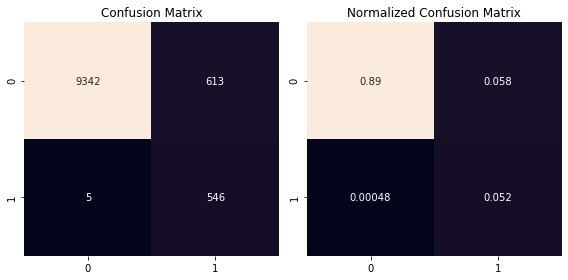

In [27]:
# Visualise confusion matrix:
cm = confusion_matrix(y, pipe_xgb_best.predict(X_dum))
cm_norm = confusion_matrix(y, pipe_xgb_best.predict(X_dum), normalize='all')
classes = pipe_xgb_best.classes_

fig, ax = plt.subplots(ncols=2, figsize=(8,4))
sns.heatmap(pd.DataFrame(cm, index=classes, columns=classes), annot=True, fmt='d', cbar=False, ax=ax[0])
ax[0].set_title('Confusion Matrix')
sns.heatmap(pd.DataFrame(cm_norm, index=classes, columns=classes), annot=True, cbar=False, ax=ax[1])
ax[1].set_title('Normalized Confusion Matrix')

plt.tight_layout();

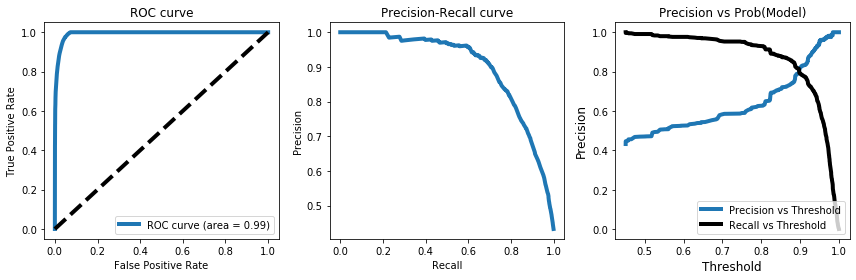

In [26]:
y_pp = pd.DataFrame(pipe_xgb_best.predict_proba(X_dum), columns=['class_0_pp', 'class_1_pp'])

# ROC curve
fpr, tpr, threshold = roc_curve(y, y_pp.class_1_pp)
roc_auc = auc(fpr, tpr)

fig, ax = plt.subplots(ncols=3, figsize=(12,4))
ax[0].plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc, linewidth=4)
ax[0].plot([0, 1], [0, 1], 'k--', linewidth=4)
ax[0].set_xlabel('False Positive Rate')
ax[0].set_ylabel('True Positive Rate')
ax[0].legend(loc="lower right")
ax[0].set_title('ROC curve')

# PR curve
precision, recall, threshold = precision_recall_curve(y, y_pp.class_1_pp)

ax[1].plot(recall, precision, label='Precision-recall curve', linewidth=4)
ax[1].set_xlabel('Recall')
ax[1].set_ylabel('Precision')
ax[1].set_title('Precision-Recall curve')

# Threshold Tuning chart
ax[2].plot(threshold, precision[:-1], label='Precision vs Threshold', linewidth=4)
ax[2].plot(threshold, recall[:-1], label='Recall vs Threshold', c='k', linewidth=4)
ax[2].set_xlabel('Threshold', fontsize=12)
ax[2].set_ylabel('Precision', fontsize=12)
ax[2].set_title('Precision vs Prob(Model)', fontsize=12)
plt.legend(loc="lower right")

plt.tight_layout();

##### Tuning XGBoost threshold

In [ ]:
def predict_at_threshold(x, threshold=0.3):
    if x >= threshold:
        return 1
    else:
        return 0

def scores_at_thresholds(probs_df):
    predictions = [probs_df.apply(predict_at_threshold, threshold=i) 
                   for i in np.linspace(0, 1, 100)]
    scores = np.array(
    [(threshold, 
      accuracy_score(y, predictions[i]),
      precision_score(y, predictions[i]),
      recall_score(y, predictions[i]), 
      f1_score(y, predictions[i])) 
     for i, threshold in enumerate(np.linspace(0, 1, 100))])
    return scores

/Users/Noah/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


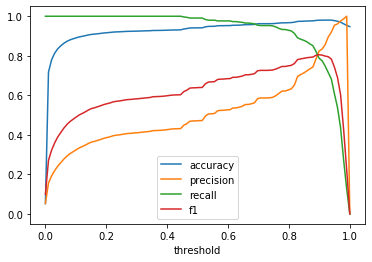

In [33]:
scores = scores_at_thresholds(y_pp.class_1_pp)

plt.plot(scores[:, 0], scores[:, 1], label='accuracy')
plt.plot(scores[:, 0], scores[:, 2], label='precision')
plt.plot(scores[:, 0], scores[:, 3], label='recall')
plt.plot(scores[:, 0], scores[:, 4], label='f1')
plt.legend()
plt.xlabel('threshold')
plt.show();

In [20]:
# Pickle if results are satisfactory:
gs_xgb_pickle_name = './pickle_objects/gs_xgb_best_score_{}%.pkl'.format(np.round(gs_xgb.best_score_*100,2))
pickle.dump(gs_xgb.best_estimator_, open(gs_xgb_pickle_name, 'wb'))

### Preparing the Tableau visualisation
Creating predict and predict_vs_actuals columns for Tableau visualisation
Tableau .twb object saved in this repository to visualise results

In [34]:
'''Based on tuning chart above, a 90% threshold was chosen for best f1-score'''
pred_90pct = y_pp.class_1_pp.apply(predict_at_threshold, threshold=0.9)

In [42]:
train_predict_df = pd.read_csv('./datasets/train_predict_df.csv')

pipe_lr_best.fit(X_dum, y)
train_predict_df['lr_predict'] = pipe_lr_best.predict(X_dum)
pipe_lrcv_best.fit(X_dum, y)
train_predict_df['lrcv_predict'] = pipe_lrcv_best.predict(X_dum)
pipe_dt_best.fit(X_dum, y)
train_predict_df['dt_predict'] = pipe_dt_best.predict(X_dum)
pipe_rf_best.fit(X_dum, y)
train_predict_df['rf_predict'] = pipe_rf_best.predict(X_dum)
pipe_bc_best.fit(X_dum, y)
train_predict_df['bc_predict'] = pipe_bc_best.predict(X_dum)
pipe_gb_best.fit(X_dum, y)
train_predict_df['gb_predict'] = pipe_gb_best.predict(X_dum)
pipe_xgb_best.fit(X_dum, y)
train_predict_df['xgb_predict'] = pipe_xgb_best.predict(X_dum)
train_predict_df['xgb_tuned_predict'] = pred_90pct

train_predict_df.to_csv('./datasets/train_predict_df.csv')

/Users/Noah/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (27,35,37,93) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [43]:
def vs_actual_labeller(df):
    if df.iloc[0] and df.iloc[1]:
        label = 'VirusCaught'
    elif df.iloc[0] and not df.iloc[1]:
        label = 'VirusMissed'
    elif not df.iloc[0] and df.iloc[1]:
        label = 'FalseAlarm'
    else:
        label = 'NoVirus'
    return label

In [44]:
train_predict_df = pd.read_csv('./datasets/train_predict_df.csv')

train_predict_df['lr_vs_actual'] = train_predict_df[['WnvPresent','lr_predict']].apply(vs_actual_labeller, axis=1)
train_predict_df['lrcv_vs_actual'] = train_predict_df[['WnvPresent','lrcv_predict']].apply(vs_actual_labeller, axis=1)
train_predict_df['dt_vs_actual'] = train_predict_df[['WnvPresent','dt_predict']].apply(vs_actual_labeller, axis=1)
train_predict_df['rf_vs_actual'] = train_predict_df[['WnvPresent','rf_predict']].apply(vs_actual_labeller, axis=1)
train_predict_df['bc_vs_actual'] = train_predict_df[['WnvPresent','bc_predict']].apply(vs_actual_labeller, axis=1)
train_predict_df['gb_vs_actual'] = train_predict_df[['WnvPresent','gb_predict']].apply(vs_actual_labeller, axis=1)
train_predict_df['xgb_vs_actual'] = train_predict_df[['WnvPresent','xgb_predict']].apply(vs_actual_labeller, axis=1)
train_predict_df['xgb_tuned_vs_actual'] = train_predict_df[['WnvPresent','xgb_tuned_predict']].apply(vs_actual_labeller, axis=1)

train_predict_df.to_csv('./datasets/train_predict_df.csv')

/Users/Noah/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (28,36,38,94) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Conclusion

- Most classification methods could time the incidence of the virus correctly based on weather feaures, however they would indiscriminately flash that all traps will show viral incidences. The trap locations, due to their sparsity, didn't feature prominently enough.
- XGBoost however was able to outperform the other models with a significantly higher ROC AUC, as also shown in the Tableau visualisation, and able to discriminate based on location effetively for the training set.
- Tuning the threshold to be more discriminating predicting for the virus improves the precision further still.

## Test Run
- For Kaggle submission

#### Setting up (X_test)

In [29]:
X_test = test_df[['Species','Trap','weather_PC1','weather_PC2','weather_PC3','weather_PC4','weather_PC5',
                  'weather_PC6','weather_PC7','weather_PC8','weather_PC9','weather_PC10','isSpray']]

# create a mapping dictionary for columns newly found in test data:
cols_map = {'UNSPECIFIED CULEX':'CULEX PIPIENS/RESTUANS',
            'T234':'T005','T002A':'T002','T002B':'T002','T065A':'T065','T090A':'T090','T090B':'T090',
            'T090C':'T090','T128A':'T128','T200A':'T200','T200B':'T200','T218A':'T218','T218B':'T218',
            'T218C':'T218'}

# implement mappings for Species and Trap:
X_test['Species'] = [row if row in set(X.Species) else cols_map[str(row)] for row in X_test.Species]
X_test['Trap'] = [row if row in set(X.Trap) else cols_map[str(row)] for row in X_test.Trap]

X_test_dum = pd.get_dummies(X_test, drop_first=True, columns=['Species','Trap'])

/Users/Noah/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/Users/Noah/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


#### Model predictions

In [30]:
#pipe_gb_best.fit(X_dum, y)
submit_df = pd.DataFrame(pipe_xgb_best.predict_proba(X_test_dum)[:,1], columns=['WnvPresent'])
submit_df.insert(0, 'Id', list(range(1,len(X_test.index)+1)))
submit_df.to_csv('./datasets/submit_df.csv', index=False)

#lrcv.fit(X_dum, y)
# submit_df = pd.DataFrame(lrcv.predict_proba(X_test_dum)[:,1], columns=['WnvPresent'])
# submit_df.insert(0, 'Id', list(range(1,len(X_test.index)+1)))
# submit_df.to_csv('./datasets/submit_df.csv', index=False)

#### Outcome

- XGBoost test AUC of 69% vs. the Training CV AUC of 81% indicates an overfitting problem.
- Further experimentation tuning parameters such as Cover and Tree Complexity (gamma) needed to improve on this.